# Project Description

**Develop a feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.**

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* **Thumbs up**:  Increase the volume
* **Thumbs down**: Decrease the volume
* **Left swipe**: 'Jump' backwards 10 seconds
* **Right swipe**: 'Jump' forward 10 seconds  
* **Stop**: Pause the movie

## Objectives

**Generator**: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

**Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

**Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

**import packages**

In [1]:
import numpy as np
import os
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# We set the random seed so that the results don't vary drastically.

np.random.seed(30)

import random as rn
from keras import backend as K
import tensorflow as tf

rn.seed(30)
tf.random.set_seed(30)

In [3]:
# keras api
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Read the folder names for training and validation:
* Set the batch_size here, in such a way that you are able to use the GPU in full capacity. 
* Keep increasing the batch size until the machine throws an error.

# Data Collection
1. Select training and validation data for ablaion experiment.

* Memory and Computation Efficient

In [4]:
# train and validatiaon data creator with ablation -- select random files for each class
'''
e.g. : when ablation is 10, then 10 folders for each label will be selected.
'''
def get_data(path, ablation=None):
    
    # trainining folder directory document
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    # validation folder directory document
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    
    # count for  for 5 classes(classification) -- class label occurence in train folder 
    # -- class labels = 0,1,2,3,4
    # -- class labels counts = [0,0,0,0,0] -- indices match with class labels
    train_counts = np.zeros(5) 
    
    # training data
    train_data = []
    # valdiatin data
    val_data = []
    
    # when ablation is not None and a limit value is provided, select data till ablation limit
    if ablation is not None:
        # iterating train doc -- path of training data folders
        for doc in train_doc:
            # labels of class in folder -- [0,1,2,3,4]
            label = int(doc.strip().split(';')[2])
            # select folders from training data till ablation limit
            # if count of label is less than ablatin limit, then only select value
            if train_counts[label] < ablation:
                # add folder path to training document
                train_data.append(doc)
                # increase count of label by 1
                train_counts[label] += 1 
                
        # count for  for 5 classes(classification) -- class label occurence in validation folder 
        # -- class labels = 0,1,2,3,4
        # -- class labels counts = [0,0,0,0,0] -- indices match with class labels
        val_counts = np.zeros(5)
        # iterating validation doccument -- path of validation data folders
        for doc in val_doc:
            # if count of label is less than ablatin limit, then only select value
            label = int(doc.strip().split(';')[2])
            # select folders from validation data till ablation limit
            # if count of label is less than ablatin limit, then only select value
            if val_counts[label] < ablation:
                # add folder path to validation document
                val_data.append(doc)
                # increase count of label by 1
                val_counts[label] += 1
    # when ablation is None pass full training and validation data, and some ablation data is provided
    else:
        train_data, val_data = train_doc, val_doc
        
    return train_data, val_data

In [5]:
# generate training and validation data

train_doc, val_doc = get_data('../DATA Human Gestures/', ablation=10)

In [6]:
# model hyper-parameters -- experimentation

# experiment with the batch size
batch_size = 128

# augmentation of Data
enable_augmentation = False

# image sequence ids
img_idx = range(5,20,2)

# image dimensions
dim_x, dim_y = 128, 128

# Data Generation

* It is there in place so that the generator is always ready to yield a batch once next() is called once it is called at the start of training. 
* Even after one pass over the data is completed (after the for loop is completed and the batch for the remainder datapoints is yielded), upon the subsequent next() call (at the start of the next epoch), the processing starts from the command 't=np.random.permuatation(folder_list)'. 
* In this way, the generator requires very less memory while training.


* In the generator, 
    - Preprocess the images as we have images of 2 different dimensions,
    - as well as create a batch of video frames.

* Experiment with `img_idx`, `y`,`z` and normalization for high accuracy.

In [7]:
# custom data generator

def generator(
    source_path=None, # root directory
    folder_list=None, # document
    img_idx=None, # list of index of images
    batch_size=128, # data size in each batch
    is_train = False,
    augmentation=False,
    debug = False,
):
    '''
    img_idx: 
        a. experiment with creating a list of image numbers you want to use for a particular video, 
        b. out of all frame images in each folder -- improve performance
    '''    
    # samples in image
    x = len(img_idx)
    # image dimenstion
    y, z = dim_x, dim_y
    
    # continuos flow of data -- for several epochs
    while True:
        
        # doubling the data for augmentation
        # randomly select from sequence
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
                
        # 1 sequence = 1 video = 30 image collection
        # calculate the number of batches to call in each iterations -- (number of video frames)/(batch size) -- 30/batch_size
        num_batches = 6
        
        # we iterate over the number of batches
        for batch in range(num_batches):     
            # creating 0 tensors -- empty containers -- load images
            # x is the number of images you use for each video = img_idx
            # (y,z) is the final size of the input images and  = height,width
            # 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,3))
            # batch_labels is the one hot ecnoding representation of the output -- 5 classes
            batch_labels = np.zeros((batch_size,5)) 

            # iterate over the batch_size
            for folder in range(batch_size): 
                # read all the images in the video image sequence folder
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmentation and rn.randint(0,1) == 1:
                    #randomly selecting augmentation type
                    aug_type = rn.randint(0, 4) 
                
                # Iterate iver the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx):
                    # selectively take images
                    image = mpimg.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))
        
                    # crop the images and resize them. Note that the images are of 2 different shape 
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] > image.shape[0]:
                            diff_px = image.shape[1] - image.shape[0]
                            crop_start = diff_px//2
                            crop_end = crop_start + image.shape[0]
                            image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]
                    
                    # resize image
                    resized_im = image.resize(y,z)
                    
                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)
                    
                    # normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (resized_im[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            #you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels 

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '../DATA Human Gestures/train' 
val_path =  '../DATA Human Gestures/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 50
# validation sequences = 50
# epochs = 50


In [9]:
# testing generative 
test_gen = generator(
    source_path=train_path,folder_list=train_doc,img_idx=img_idx,batch_size=batch_size,
    is_train=True,augmentation=True,debug=True,
)

ValueError: resize only works on single-segment arrays

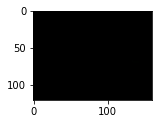

In [10]:
next(test_gen)